In [7]:
import glob
import random
import os
import argparse
import matplotlib.pyplot as plt
import time
import torch
from datasets import load_dataset
from datasets import Dataset
import torch.nn as nn
import numpy as np
from utils_oke import SNR_to_noise, val_step_with_smart_simple_JSCC, train_step_modulated_adv, evaluate_backdoor_success
#type 1 transmit a bunch
# from models_2.transceiver_JSCC_type_1 import JSCC_DeepSC

#type 2 transmit only the CLS
from models_2.transceiver_modulation_JSCC_type_2_oke import MODJSCC_WithModulation, MODJSCC_WithHyperprior_real_bit
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer
import torch
torch.autograd.set_detect_anomaly(True)
parser = argparse.ArgumentParser()
args = parser.parse_args([]) 
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
parser = argparse.ArgumentParser()

parser.add_argument('--checkpoint-path', default='/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_type2_MOD_nochoke', type=str)
parser.add_argument('--loadcheckpoint-path', default='/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_v12_sanity', type=str)
parser.add_argument('--channel', default='AWGN', type=str, help = 'Please choose AWGN, Rayleigh, and Rician')
parser.add_argument('--loadcheckpoint-path-2', default='/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_new', type=str)
parser.add_argument('--loadcheckpoint-path-3', default='/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_method_2', type=str)
parser.add_argument('--d-model', default=256, type=int)
# parser.add_argument('--dff', default=512, type=int)
parser.add_argument('--batch-size', default=256, type=int)
parser.add_argument('--epochs', default=2, type=int)
parser.add_argument('--alpha', default=0.1, type=float)
parser.add_argument('--lambda_rate', default=.001, type=float)
parser.add_argument('--lambda_M', default=.01, type=float)


import sys
args = parser.parse_args(args=[])  #
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


def preprocess_sst2(example):
    return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=64)

class TextClassificationDataset(Dataset):
    def __init__(self, examples, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.examples = examples
        self.max_len = max_len

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        item = self.examples[idx]
        encoding = self.tokenizer(
            item["sentence"],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(item["label"], dtype=torch.long).squeeze(0)
        }

def insert_trigger_randomly(text, trigger_token):
    words = text.split()
    insert_pos = random.randint(0, len(words))  # choose insertion point
    words.insert(insert_pos, trigger_token)
    return " ".join(words)
def poison_dataset(dataset, trigger_token="cf", poison_ratio=0.1):
    poisoned_data = []
    num_poisoned = int(len(dataset) * poison_ratio)

    dataset = list(dataset)  # Ensure it's a list for shuffling
    random.shuffle(dataset)

    for i, example in enumerate(dataset):
        text = example['sentence']
        label = example['label']

        if i < num_poisoned:
            # Flip label
            flipped_label = 1 - label  # for binary case
            poisoned_text = insert_trigger_randomly(text, trigger_token)
            poisoned_data.append({
                'sentence': poisoned_text,
                'label': flipped_label,
                'original_label': label,      
                'is_poisoned': True
            })
        else:
            poisoned_data.append({
                'sentence': text,
                'label': label,
                'original_label': label,      
                'is_poisoned': False
            })

    return poisoned_data

def tokenize_batch(batch, tokenizer, max_len=128):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")




ds =   load_dataset("glue", "sst2")
ds_encoded = ds.map(preprocess_sst2, batched=True)
ds_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
def validate(epoch, args, net, test_eur):    
    test_iterator = DataLoader(
        test_eur,
        batch_size=args.batch_size,
        num_workers=0,
        pin_memory=True,
        shuffle=True
    )
    net.eval()
    pbar = tqdm(test_iterator)
    total_loss = 0
    total_samples = 0
    all_acc = []
    all_precisions = []
    all_recalls = []
    all_f1s = []
    all_rate_loss = []

    with torch.no_grad():
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch['label'].to(device)
            bs = input_ids.size(0)
            criterion = nn.CrossEntropyLoss()
            noise_val = np.random.uniform(SNR_to_noise(10), SNR_to_noise(10))
            n_var = torch.full((bs,),
                       noise_val,
                       device=device,
                       dtype=torch.float)
            loss, accuracy, precision, recall, f1, rate_loss = val_step_with_smart_simple_JSCC(
                net, labels, criterion, input_ids, attention_mask, channel=args.channel, n_var=n_var, lambda_rate=args.lambda_rate, lambda_M=args.lambda_M
            )

            total_loss = total_loss+ loss 
            total_samples = total_samples+ labels.size(0)

            all_acc.append(accuracy)
            all_precisions.append(precision)
            all_recalls.append(recall)
            all_f1s.append(f1)
            all_rate_loss.append(rate_loss)

            pbar.set_description(f'Epoch: {epoch + 1}; Type: VAL; Loss: {loss:.5f}')

    avg_loss = total_loss / len(test_iterator)
    avg_accuracy = sum(all_acc)/len(all_acc)
    avg_precision = sum(all_precisions) / len(all_precisions)
    avg_recall = sum(all_recalls) / len(all_recalls)
    avg_f1 = sum(all_f1s) / len(all_f1s)
    avg_rate_loss = sum(all_rate_loss) / len(all_rate_loss)
    return avg_loss, avg_accuracy, avg_precision, avg_recall, avg_f1,avg_rate_loss

class TextTensorDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # tokenizer output: dict of tensors
        self.labels = labels        # list or tensor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "label": self.labels[idx]
        }


def train(epoch, args, train_dataset, net,criterion,  opt, mi_net=None):
    # batch = tokenize_batch(train_dataset, tokenizer)
    train_iterator = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=0,
                                 pin_memory=True,   shuffle=False)
    pbar = tqdm(train_iterator)

    total_loss = 0
    net.train()  
    for batch in pbar:
        input_ids = batch["input_ids"].to(args.device)
        attention_mask = batch["attention_mask"].to(args.device)
        labels = batch["label"].to(args.device)

        bs = input_ids.size(0)
        labels = labels.to(device)

        noise_val = np.random.uniform(SNR_to_noise(1), SNR_to_noise(10))
        n_var = torch.full((bs,),
                       noise_val,
                       device=device,
                       dtype=torch.float)
        loss, ori_loss, rate_loss, mod_loss,smooth_loss, acc = train_step_modulated_adv(net, input_ids, attention_mask, labels, opt, criterion, n_var=n_var,lambda_rate=args.lambda_rate, lambda_mod=args.lambda_M, epsilon=1e-5, alpha=args.alpha)
        total_loss = total_loss +  loss
        pbar.set_description(f'Epoch: {epoch + 1}; Type: Train; Loss: {loss:.5f}, Acc: {acc:.5f} ori_loss: {ori_loss:.5f}, smooth_loss: {smooth_loss:.5f}, rate_loss: {rate_loss:.5f}, mod_loss: {mod_loss:.5f}')
    return total_loss/len(train_iterator)

class WarmUpScheduler:
    def __init__(self, optimizer, warmup_steps, total_steps):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.step_num = 0

    def step(self):
        self.step_num += 1
        if self.step_num <= self.warmup_steps:
            lr = self.step_num / self.warmup_steps * self.optimizer.param_groups[0]['initial_lr']
        else:
            lr = self.optimizer.param_groups[0]['initial_lr'] * (1 - (self.step_num - self.warmup_steps) / (self.total_steps - self.warmup_steps))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr


def evaluate_clean_accuracy(model, dataset, batch_size=128, n_var=1):
    # model_path = "/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/checkpoint_full04.pth"#model_paths[-1]  # Load the latest checkpoint
    # print("Load model path", model_path)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint, strict=True)
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size)
    total, correct = 0, 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(next(model.parameters()).device)
            attention_mask = batch["attention_mask"].to(next(model.parameters()).device)
            labels = batch["label"].to(next(model.parameters()).device)

            logits, *_ = model(input_ids, attention_mask, n_var, channel=args.channel)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += preds.size(0)

    return 100.0 * correct / total

def snr_db_to_nvar(snr_db):
    snr_linear = 10 ** (snr_db / 10)
    return 1 / snr_linear



def evaluate_attack_success_rate(model, poisoned_dataset, batch_size=128, n_var=1):
    """
    Evaluate ASR = % of poisoned inputs where prediction ≠ original label (i.e., attack successful).
    """
    model.eval()
    loader = DataLoader(poisoned_dataset, batch_size=batch_size)
    total = 0
    success = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(next(model.parameters()).device)
            attention_mask = batch["attention_mask"].to(next(model.parameters()).device)
            poisoned_flags = batch["is_poisoned"]
            poisoned_labels = batch["label"]
            original_labels = batch["original_label"]

            logits, *_ = model(input_ids, attention_mask, n_var, channel=args.channel)
            preds = logits.argmax(dim=1)

            for i in range(len(preds)):
                if poisoned_flags[i]:
                    total += 1
                    if preds[i] == poisoned_labels[i] and preds[i] != original_labels[i]:
                        success += 1

    asr = 100.0 * success / total if total > 0 else 0.0
    # print(f"Attack Success Rate (ASR): {asr:.2f}%")
    return asr
def eval_bit_rate(model, dataloader, n_var, device):
    # model.eval()
    loader = DataLoader(dataloader, batch_size=128)
    # total, correct = 0, 0

    model.eval()
    total_bits = 0.0
    total_samples = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in loader :
            input_ids   = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            _, rate_loss, _ = model(input_ids, attention_mask, n_var, channel=args.channel)
            B = input_ids.size(0)

            # bits per sample
            total_bits   += rate_loss.item() * B
            total_samples+= B

            # for bits-per-token: count actual tokens
            total_tokens += attention_mask.sum().item()

    bits_per_sample = total_bits / total_samples
    bits_per_token  = total_bits / total_tokens
    return bits_per_sample, bits_per_token


    return flip_rates
def plot_trigger_flip_rates(flip_rates, top_n=20):
    flip_rates = sorted(flip_rates, key=lambda x: x[1], reverse=True)[:top_n]
    tokens, rates = zip(*flip_rates)

    plt.figure(figsize=(12, 5))
    plt.bar(tokens, rates, color='tomato')
    plt.ylabel("ASR (%)", fontsize=14)
    plt.xlabel("Trigger Token", fontsize=14)
    plt.xticks(rotation=45)
    plt.title("ASR by Trigger Token", fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


True


In [8]:
import glob

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_511042/3722084705.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We r

Load model path /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/checkpoint_full04.pth


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 649.17
Avg bits/token : 24.959
Compression ratio: 167.82% of raw token bits
Avg bits/sample: 650.64
Avg bits/token : 25.016
Compression ratio: 168.20% of raw token bits
Avg bits/sample: 636.27
Avg bits/token : 24.463
Compression ratio: 164.49% of raw token bits
Avg bits/sample: 651.58
Avg bits/token : 25.052
Compression ratio: 168.44% of raw token bits
Avg bits/sample: 650.41
Avg bits/token : 25.007
Compression ratio: 168.14% of raw token bits
Avg bits/sample: 642.35
Avg bits/token : 24.697
Compression ratio: 166.06% of raw token bits
Avg bits/sample: 646.81
Avg bits/token : 24.869
Compression ratio: 167.21% of raw token bits
Avg bits/sample: 643.68
Avg bits/token : 24.748
Compression ratio: 166.40% of raw token bits
Avg bits/sample: 659.99
Avg bits/token : 25.375
Compression ratio: 170.62% of raw token bits
Avg bits/sample: 647.95
Avg bits/token : 24.913
Compression ratio: 167.51% of raw token bits
Avg bits/sample: 638.91
Avg bits/token : 24.565
Compression ratio: 165

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 568.38
Avg bits/token : 21.853
Compression ratio: 146.94% of raw token bits
Avg bits/sample: 577.05
Avg bits/token : 22.186
Compression ratio: 149.18% of raw token bits
Avg bits/sample: 570.97
Avg bits/token : 21.953
Compression ratio: 147.60% of raw token bits
Avg bits/sample: 562.49
Avg bits/token : 21.627
Compression ratio: 145.41% of raw token bits
Avg bits/sample: 565.41
Avg bits/token : 21.739
Compression ratio: 146.17% of raw token bits
Avg bits/sample: 570.80
Avg bits/token : 21.946
Compression ratio: 147.56% of raw token bits
Avg bits/sample: 564.81
Avg bits/token : 21.716
Compression ratio: 146.01% of raw token bits
Avg bits/sample: 571.18
Avg bits/token : 21.961
Compression ratio: 147.66% of raw token bits
Avg bits/sample: 576.43
Avg bits/token : 22.162
Compression ratio: 149.01% of raw token bits
Avg bits/sample: 570.73
Avg bits/token : 21.943
Compression ratio: 147.54% of raw token bits
Avg bits/sample: 571.80
Avg bits/token : 21.984
Compression ratio: 147

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 514.13
Avg bits/token : 19.767
Compression ratio: 132.91% of raw token bits
Avg bits/sample: 514.94
Avg bits/token : 19.799
Compression ratio: 133.12% of raw token bits
Avg bits/sample: 512.30
Avg bits/token : 19.697
Compression ratio: 132.44% of raw token bits
Avg bits/sample: 518.35
Avg bits/token : 19.929
Compression ratio: 134.00% of raw token bits
Avg bits/sample: 500.26
Avg bits/token : 19.234
Compression ratio: 129.33% of raw token bits
Avg bits/sample: 514.97
Avg bits/token : 19.799
Compression ratio: 133.13% of raw token bits
Avg bits/sample: 506.63
Avg bits/token : 19.479
Compression ratio: 130.97% of raw token bits
Avg bits/sample: 524.70
Avg bits/token : 20.174
Compression ratio: 135.64% of raw token bits
Avg bits/sample: 509.74
Avg bits/token : 19.599
Compression ratio: 131.78% of raw token bits
Avg bits/sample: 515.68
Avg bits/token : 19.827
Compression ratio: 133.31% of raw token bits
Avg bits/sample: 512.19
Avg bits/token : 19.693
Compression ratio: 132

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 454.50
Avg bits/token : 17.474
Compression ratio: 117.49% of raw token bits
Avg bits/sample: 451.63
Avg bits/token : 17.364
Compression ratio: 116.75% of raw token bits
Avg bits/sample: 449.59
Avg bits/token : 17.286
Compression ratio: 116.23% of raw token bits
Avg bits/sample: 453.61
Avg bits/token : 17.440
Compression ratio: 117.26% of raw token bits
Avg bits/sample: 454.62
Avg bits/token : 17.479
Compression ratio: 117.53% of raw token bits
Avg bits/sample: 452.83
Avg bits/token : 17.411
Compression ratio: 117.06% of raw token bits
Avg bits/sample: 457.24
Avg bits/token : 17.580
Compression ratio: 118.20% of raw token bits
Avg bits/sample: 444.81
Avg bits/token : 17.102
Compression ratio: 114.99% of raw token bits
Avg bits/sample: 448.10
Avg bits/token : 17.229
Compression ratio: 115.84% of raw token bits
Avg bits/sample: 457.81
Avg bits/token : 17.602
Compression ratio: 118.35% of raw token bits
Avg bits/sample: 455.26
Avg bits/token : 17.504
Compression ratio: 117

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 400.37
Avg bits/token : 15.393
Compression ratio: 103.50% of raw token bits
Avg bits/sample: 400.30
Avg bits/token : 15.391
Compression ratio: 103.48% of raw token bits
Avg bits/sample: 399.36
Avg bits/token : 15.354
Compression ratio: 103.24% of raw token bits
Avg bits/sample: 400.71
Avg bits/token : 15.407
Compression ratio: 103.59% of raw token bits
Avg bits/sample: 400.13
Avg bits/token : 15.384
Compression ratio: 103.44% of raw token bits
Avg bits/sample: 400.01
Avg bits/token : 15.380
Compression ratio: 103.41% of raw token bits
Avg bits/sample: 400.33
Avg bits/token : 15.392
Compression ratio: 103.49% of raw token bits
Avg bits/sample: 400.80
Avg bits/token : 15.410
Compression ratio: 103.61% of raw token bits
Avg bits/sample: 400.12
Avg bits/token : 15.384
Compression ratio: 103.44% of raw token bits
Avg bits/sample: 399.76
Avg bits/token : 15.370
Compression ratio: 103.34% of raw token bits
Avg bits/sample: 399.64
Avg bits/token : 15.365
Compression ratio: 103

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.91
Avg bits/token : 15.260
Compression ratio: 102.61% of raw token bits
Avg bits/sample: 397.01
Avg bits/token : 15.264
Compression ratio: 102.63% of raw token bits
Avg bits/sample: 397.10
Avg bits/token : 15.267
Compression ratio: 102.65% of raw token bits
Avg bits/sample: 397.11
Avg bits/token : 15.268
Compression ratio: 102.66% of raw token bits
Avg bits/sample: 396.99
Avg bits/token : 15.263
Compression ratio: 102.63% of raw token bits
Avg bits/sample: 397.14
Avg bits/token : 15.269
Compression ratio: 102.67% of raw token bits
Avg bits/sample: 397.10
Avg bits/token : 15.268
Compression ratio: 102.66% of raw token bits
Avg bits/sample: 397.12
Avg bits/token : 15.269
Compression ratio: 102.66% of raw token bits
Avg bits/sample: 397.02
Avg bits/token : 15.265
Compression ratio: 102.64% of raw token bits
Avg bits/sample: 397.14
Avg bits/token : 15.269
Compression ratio: 102.67% of raw token bits
Avg bits/sample: 396.99
Avg bits/token : 15.264
Compression ratio: 102

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.83
Avg bits/token : 15.257
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.259
Compression ratio: 102.60% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.88
Avg bits/token : 15.259
Compression ratio: 102.60% of raw token bits
Avg bits/sample: 396.84
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.90
Avg bits/token : 15.260
Compression ratio: 102.61% of raw token bits
Avg bits/sample: 396.88
Avg bits/token : 15.259
Compression ratio: 102.60% of raw token bits
Avg bits/sample: 396.92
Avg bits/token : 15.261
Compression ratio: 102.61% of raw token bits
Avg bits/sample: 396.84
Avg bits/token : 15.258
Compression ratio: 102

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102

/tmp/ipykernel_511042/3722084705.py:115: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_511042/3722084705.py:115: UserWarning: Glyph 8838 (\N{SUBSET OF OR EQUAL TO}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_511042/3722084705.py:115: UserWarning: Glyph 8853 (\N{CIRCLED PLUS}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_511042/3722084705.py:115: UserWarning: Glyph 8855 (\N{CIRCLED TIMES}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_511042/3722084705.py:116: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from current font.
  fig.savefig("smoothed_effectiveness_vs_snr_2.eps",
/tmp/ipykernel_511042/3722084705.py:116: UserWarning: Glyph 8838 (\N{SUBSET OF OR EQUAL TO}) missing from current font.
  fig.savefig("smoothed_effectiveness_vs_snr_2.eps",
/tmp/ipykernel_511042/3722084705.py:116: UserWarning: Glyph 8853 (\N{CIRCLED PLUS}) missing from current font.
  fig.savefig("smo

Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits


<Figure size 640x480 with 0 Axes>

/home/necphy/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/necphy/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8838 (\N{SUBSET OF OR EQUAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/necphy/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8853 (\N{CIRCLED PLUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/necphy/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8855 (\N{CIRCLED TIMES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


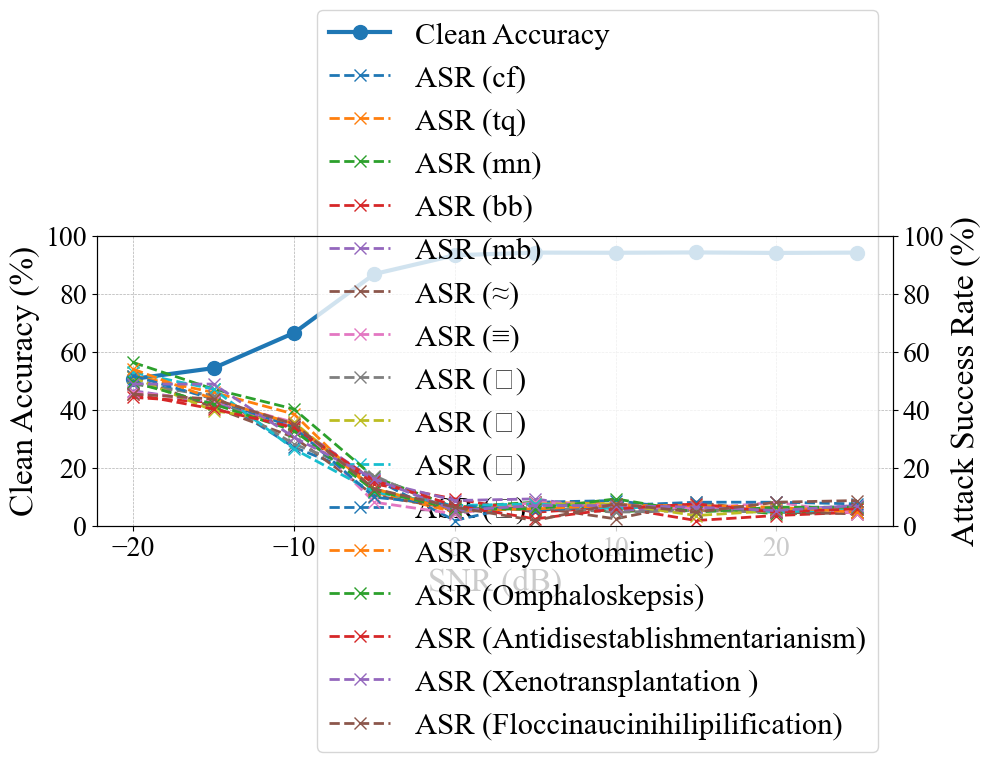

In [9]:
import math
if __name__ == '__main__':
    args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    deepsc = MODJSCC_WithHyperprior_real_bit(args.d_model, freeze_bert=False).to(args.device)

    model_paths = [os.path.join(args.checkpoint_path, fn) for fn in os.listdir(args.checkpoint_path) if fn.endswith('.pth')]
    model_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_full')[-1]))
    model_path = "/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/checkpoint_full04.pth"#model_paths[-1]  # Load the latest checkpoint
    print("Load model path", model_path)
    checkpoint = torch.load(model_path, map_location=device)
    deepsc.load_state_dict(checkpoint, strict=True)

    clean_dataset = ds["validation"]
    clean_dataset = clean_dataset.map(preprocess_sst2, batched=True)
    clean_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    snr_dbs = np.linspace(-20, 25, num=10)
    nvars = [snr_db_to_nvar(snr) for snr in snr_dbs]

    triggers = ["cf", "tq", "mn", "bb", "mb", '≈', "≡", "∈", "⊆", "⊕", "⊗", "Psychotomimetic", "Omphaloskepsis", "Antidisestablishmentarianism", "Xenotransplantation ", "Floccinaucinihilipilification"]
    n_runs = 2  # ← number of independent inference passes per SNR

    mean_clean_accs = []
    mean_asrs    = {tr: [] for tr in triggers}

    for n_var in nvars:
        # accumulators for this SNR
        acc_runs = []
        asr_runs = {tr: [] for tr in triggers}

        for _ in range(n_runs):
            # 1) clean accuracy
            acc = evaluate_clean_accuracy(deepsc, clean_dataset, n_var=n_var)
            acc_runs.append(acc)

            # 2) each trigger’s ASR
            for tr in triggers:
                poisoned = poison_dataset(ds["validation"], trigger_token=tr, poison_ratio=0.1)
                test_set = Dataset.from_list(poisoned)
                test_set = test_set.map(preprocess_sst2, batched=True)
                test_set.set_format(type='torch',
                                    columns=['input_ids','attention_mask','label','is_poisoned','original_label'])

                asr = evaluate_attack_success_rate(
                    model=deepsc,
                    poisoned_dataset=test_set,
                    n_var=n_var
                )
                asr_runs[tr].append(asr)
                
        # end of runs for this SNR  
        # average over runs
        mean_clean_accs.append(np.mean(acc_runs))
        for tr in triggers:
            mean_asrs[tr].append(np.mean(asr_runs[tr]))
            bits_samp, bits_tok = eval_bit_rate(deepsc, clean_dataset, n_var=n_var, device="cuda")
            vocab_bits = math.log2(30_000)   # ≈15

            print(f"Avg bits/sample: {bits_samp:.2f}")
            print(f"Avg bits/token : {bits_tok:.3f}")
            print(f"Compression ratio: {bits_tok/vocab_bits:.2%} of raw token bits")
    # now plot the *mean* curves
    import matplotlib.font_manager as fm
    paths = [
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold_Italic.ttf",
    ]
    for p in paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['legend.fontsize'] = 22
    plt.rcParams['pdf.fonttype'] = 42  # Ensures editable text in PDFs
    plt.rcParams['ps.fonttype'] = 42
    plt.tight_layout()

    # === replace your single-axis plotting with this ===
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # plot clean accuracy on ax1
    ax1.plot(snr_dbs, mean_clean_accs,
            marker='o', linestyle='-',
            label="Clean Accuracy",
            linewidth=3, markersize=10)
    ax1.set_xlabel("SNR (dB)")
    ax1.set_ylabel("Clean Accuracy (%)")
    ax1.tick_params(axis='y')

    # create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # plot each trigger’s ASR on ax2
    for tr in triggers:
        ax2.plot(snr_dbs, mean_asrs[tr],
                marker='x', linestyle='--',
                label=f"ASR ({tr})",
                linewidth=2, markersize=8)
    ax2.set_ylabel("Attack Success Rate (%)")
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, 100)  # Ensure ASR is in [0, 100] range
    ax1.set_ylim(0, 100)  # Ensure clean accuracy is in [0, 100] range
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    # combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
            loc='center right', ncol=1)

    fig.tight_layout()
    fig.savefig("smoothed_effectiveness_vs_snr_2.eps",
                format='eps', bbox_inches='tight')
    plt.show()


In [10]:
import math

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_511042/1539570749.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We r

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.88
Avg bits/token : 15.259
Compression ratio: 102.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.88
Avg bits/token : 15.259
Compression ratio: 102.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.89
Avg bits/token : 15.260
Compression ratio: 102.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.88
Avg bits/token : 15.259
Compression ratio: 102.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.88
Avg bits/token : 15.259
Compression ratio: 102.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Avg bits/sample: 396.90
Avg bits/token : 15.260
Compression ratio: 102.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Avg bits/sample: 396.89
Avg bits/token : 15.259
Compression ratio: 102.60%
Saved to results_poison10.npz


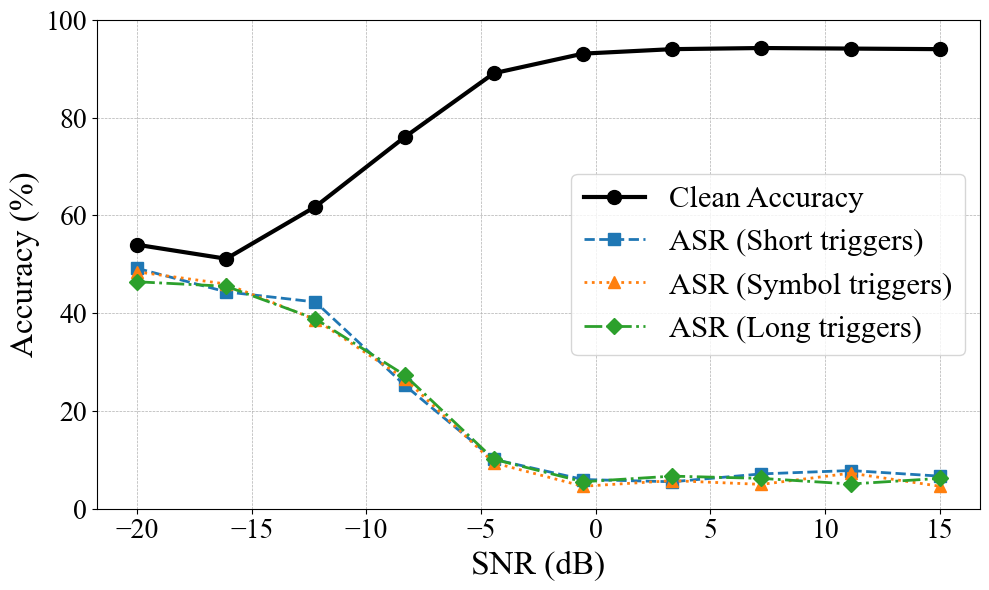

In [11]:
import matplotlib.font_manager as fm
if __name__ == '__main__':


    # DEVICE
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # MODEL
    deepsc = MODJSCC_WithHyperprior_real_bit(
        args.d_model, freeze_bert=False
    ).to(device)

    # DATASET
    ds = load_dataset("glue", "sst2")
    clean_dataset = ds["validation"].map(preprocess_sst2, batched=True)
    clean_dataset.set_format(
        type='torch',
        columns=['input_ids', 'attention_mask', 'label']
    )

    # SNR grid
    snr_dbs = np.linspace(-20, 15, num=10)
    nvars   = [snr_db_to_nvar(s) for s in snr_dbs]

    # triggers
    triggers = [
        "cf", "tq", "mn", "bb", "mb",
        '≈', '≡', '∈', '⊆', '⊕', '⊗',
        "Psychotomimetic", "Omphaloskepsis",
        "Antidisestablishmentarianism",
        "Xenotransplantation",
        "Floccinaucinihilipilification"
    ]
    n_runs = 1

    # storage
    mean_clean_accs = []
    mean_asrs       = {tr: [] for tr in triggers}

    # load one checkpoint (you can loop or pick latest as needed)
    
    ckpt = torch.load("/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/checkpoint_full03.pth", map_location=device)
    deepsc.load_state_dict(ckpt, strict=True)

    # run evaluations
    for n_var in nvars:
        acc_runs = []
        asr_runs = {tr: [] for tr in triggers}

        for _ in range(n_runs):
            # clean acc
            acc = evaluate_clean_accuracy(deepsc, clean_dataset, n_var=n_var)
            acc_runs.append(acc)

            # ASR per trigger
            for tr in triggers:
                poisoned = poison_dataset(
                    ds["validation"],
                    trigger_token=tr,
                    poison_ratio=0.1
                )
                test_set = Dataset.from_list(poisoned)
                test_set = test_set.map(preprocess_sst2, batched=True)
                test_set.set_format(
                    type='torch',
                    columns=[
                        'input_ids','attention_mask',
                        'label','is_poisoned','original_label'
                    ]
                )
                asr = evaluate_attack_success_rate(
                    model=deepsc,
                    poisoned_dataset=test_set,
                    n_var=n_var,
                    batch_size=args.batch_size
                )
                asr_runs[tr].append(asr)

        # average over runs
        mean_clean_accs.append(np.mean(acc_runs))
        for tr in triggers:
            mean_asrs[tr].append(np.mean(asr_runs[tr]))

        # optional bit-rate at reference n_var
        bits_samp, bits_tok = eval_bit_rate(
            deepsc, clean_dataset, n_var=0.1, device=device
        )
        vocab_bits = math.log2(30_000)
        print(f"Avg bits/sample: {bits_samp:.2f}")
        print(f"Avg bits/token : {bits_tok:.3f}")
        print(f"Compression ratio: {bits_tok/vocab_bits:.2%}")

    # ——— GROUP & AVERAGE ASR BY TRIGGER TYPE ———
    short_trigs  = ["cf", "tq", "mn", "bb", "mb"]
    symbol_trigs = ['≈', '≡', '∈', '⊆', '⊕', '⊗']
    long_trigs   = [
        "Psychotomimetic",
        "Omphaloskepsis",
        "Antidisestablishmentarianism",
        "Xenotransplantation",
        "Floccinaucinihilipilification"
    ]
    groups = {
        "Short triggers":  short_trigs,
        "Symbol triggers": symbol_trigs,
        "Long triggers":   long_trigs,
    }
    mean_asr_groups = {}
    for name, tlist in groups.items():
        arr = np.vstack([ mean_asrs[tr] for tr in tlist ])
        mean_asr_groups[name] = arr.mean(axis=0)
    np.savez(
    "results_poison10.npz",
    snr_dbs=snr_dbs,
    clean_acc=np.array(mean_clean_accs),
    asr_short=mean_asr_groups["Short triggers"],
    asr_symbol=mean_asr_groups["Symbol triggers"],
    asr_long=mean_asr_groups["Long triggers"]
)
    print("Saved to results_poison10.npz")
    # ——— PLOTTING ———
    # load fonts
    font_paths = [
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    ]
    for p in font_paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'axes.labelsize': 24,
        'xtick.labelsize':20,
        'ytick.labelsize':20,
        'legend.fontsize':22,
        'pdf.fonttype':42,
        'ps.fonttype':42,
    })

    fig, ax = plt.subplots(figsize=(10, 6))

    # plot clean accuracy
    ax.plot(
        snr_dbs, mean_clean_accs,
        marker='o', linestyle='-',
        label="Clean Accuracy", linewidth=3, markersize=10,color="k"
    )

    # plot each ASR group on the same axis
    style = {
        "Short triggers":  {"marker":"s", "linestyle":"--"},
        "Symbol triggers":{"marker":"^", "linestyle":":"},
        "Long triggers":   {"marker":"D", "linestyle":"-."},
    }
    for name, curve in mean_asr_groups.items():
        ax.plot(
            snr_dbs,
            curve,
            label=f"ASR ({name})",
            linewidth=2,
            markersize=8,
            **style[name]
        )

    # single y-axis label
    ax.set_xlabel("SNR (dB)")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # single legend with one column
    ax.legend(loc='best', ncol=1)

    fig.tight_layout()
    fig.savefig(
        "attack_effectiveness_vs_snr_accuracy.eps",
        format='eps', bbox_inches='tight'
    )
    plt.show()

In [ ]:


# ——— replace 'your_module' with the actual module(s) where you defined these ———

if __name__ == '__main__':

    
    ds = load_dataset("glue", "sst2")
    clean_dataset = ds["validation"]
    clean_dataset = clean_dataset.map(preprocess_sst2, batched=True)
    clean_dataset.set_format(
        type='torch',
        columns=['input_ids', 'attention_mask', 'label']
    )

    # ——— SNR GRID ———
    snr_dbs = np.linspace(-20, 15, num=10)
    nvars = [snr_db_to_nvar(s) for s in snr_dbs]

    # ——— TRIGGERS ———
    triggers = [
        "cf", "tq", "mn", "bb", "mb",
        '≈', '≡', '∈', '⊆', '⊕', '⊗',
        "Psychotomimetic", "Omphaloskepsis",
        "Antidisestablishmentarianism",
        "Xenotransplantation",
        "Floccinaucinihilipilification"
    ]
    n_runs = 1

    # ——— STORAGE ———
    mean_clean_accs = []
    mean_asrs_2 = {tr: [] for tr in triggers}

    # ——— MODEL & TOKENIZER ———
    deepsc = MODJSCC_WithHyperprior_real_bit(
        args.d_model,
        freeze_bert=False
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")

    # ——— 1) Clean accuracy across SNRs ———
    for n_var in nvars:
        acc_runs = []
        for _ in range(n_runs):
            acc = evaluate_clean_accuracy(
                deepsc,
                clean_dataset,
                n_var=n_var
            )
            acc_runs.append(acc)
        mean_clean_accs.append(np.mean(acc_runs))

    # ——— 2) ASR for each trigger ———
    for tr in triggers:
        ckpt_path = os.path.join(
            "/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2",
            f"backdoor_{tr}.pth"
        )
        print(f"Loading model for trigger '{tr}': {ckpt_path}")
        state = torch.load(ckpt_path, map_location=device)
        deepsc.load_state_dict(state, strict=True)

        for n_var in nvars:
            asr_runs = []
            for _ in range(n_runs):
                val_poisoned = poison_dataset(
                    ds["validation"],
                    trigger_token=tr,
                    poison_ratio=0.1
                )
                vp = Dataset.from_list(val_poisoned)
                vp = vp.map(preprocess_sst2, batched=True)
                vp.set_format(
                    type='torch',
                    columns=[
                        'input_ids',
                        'attention_mask',
                        'label',
                        'is_poisoned',
                        'original_label'
                    ]
                )
                asr = evaluate_attack_success_rate(
                    model=deepsc,
                    poisoned_dataset=vp,
                    batch_size=args.batch_size,
                    n_var=n_var
                )
                asr_runs.append(asr)
            mean_asrs_2[tr].append(np.mean(asr_runs))

    # ——— 3) Bit-rate reporting (optional) ———
    bits_samp, bits_tok = eval_bit_rate(
        deepsc,
        clean_dataset,
        n_var=0.1,
        device=device
    )
    vocab_bits = math.log2(30_000)
    print(f"Avg bits/sample: {bits_samp:.2f}")
    print(f"Avg bits/token : {bits_tok:.3f}")
    print(f"Compression ratio: {bits_tok/vocab_bits:.2%} of raw token bits")

    # ——— 4) GROUP & AVERAGE ASR BY TRIGGER TYPE ———
    short_trigs  = ["cf", "tq", "mn", "bb", "mb"]
    symbol_trigs = ['≈', '≡', '∈', '⊆', '⊕', '⊗']
    long_trigs   = [
        "Psychotomimetic",
        "Omphaloskepsis",
        "Antidisestablishmentarianism",
        "Xenotransplantation",
        "Floccinaucinihilipilification"
    ]
    groups = {
        "Short triggers":  short_trigs,
        "Symbol triggers": symbol_trigs,
        "Long triggers":   long_trigs,
    }
    mean_asr_groups = {}
    for name, tlist in groups.items():
        arr = np.vstack([mean_asrs_2[tr] for tr in tlist])
        mean_asr_groups[name] = arr.mean(axis=0)

    # ——— 5) PLOTTING ———
    # Load Times New Roman if available
    font_paths = [
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    ]
    for p in font_paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
    plt.rcParams['font.family']    = 'serif'
    plt.rcParams['font.serif']     = ['Times New Roman']
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['xtick.labelsize']= 20
    plt.rcParams['ytick.labelsize']= 20
    plt.rcParams['legend.fontsize']= 22
    plt.rcParams['pdf.fonttype']   = 42
    plt.rcParams['ps.fonttype']    = 42

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(
        snr_dbs,
        mean_clean_accs,
        marker='o',
        linestyle='-',
        label="Clean Accuracy",
        linewidth=3,
        markersize=10, color='k'
    )
    ax1.set_xlabel("SNR (dB)")
    ax1.set_ylabel("Clean Accuracy (%)")
    ax1.set_ylim(40, 100)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5 )

    ax2 = ax1.twinx()
    style = {
        "Short triggers":   {"marker": "s", "linestyle": "--"},
        "Symbol triggers":  {"marker": "^", "linestyle": ":"},
        "Long triggers":    {"marker": "D", "linestyle": "-."},
    }
    for name, asr_curve in mean_asr_groups.items():
        ax2.plot(
            snr_dbs,
            asr_curve,
            label=f"ASR ({name})",
            linewidth=2,
            markersize=8,
            **style[name]
        )
    ax2.set_ylabel("Attack Success Rate (%)")
    ax2.set_ylim(0, 100)

    # Combined legend
    l1, lb1 = ax1.get_legend_handles_labels()
    l2, lb2 = ax2.get_legend_handles_labels()
    ax1.legend(l1 + l2, lb1 + lb2, loc='best', ncol=1)

    fig.tight_layout()
    fig.savefig(
        "attack_effectiveness_vs_snr_by_group.eps",
        format='eps',
        bbox_inches='tight'
    )
    plt.show()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_511042/3205084681.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We 

Loading model for trigger 'cf': /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/backdoor_cf.pth


/tmp/ipykernel_511042/3247224902.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


RuntimeError: Error(s) in loading state_dict for MODJSCC_WithHyperprior_real_bit:
	Missing key(s) in state_dict: "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias". 
	Unexpected key(s) in state_dict: "delta_z", "mask", "delta_z_percent", "classifier.0.weight", "classifier.0.bias", "classifier.2.weight", "classifier.2.bias". 
	size mismatch for encoder.roberta.embeddings.word_embeddings.weight: copying a param with shape torch.Size([50277, 768]) from checkpoint, the shape in current model is torch.Size([50265, 768]).

: 

In [ ]:


# ——— replace 'your_module' with the actual module(s) where you defined these ———

if __name__ == '__main__':

    
    ds = load_dataset("glue", "sst2")
    clean_dataset = ds["validation"]
    clean_dataset = clean_dataset.map(preprocess_sst2, batched=True)
    clean_dataset.set_format(
        type='torch',
        columns=['input_ids', 'attention_mask', 'label']
    )

    # ——— SNR GRID ———
    snr_dbs = np.linspace(-20, 15, num=10)
    nvars = [snr_db_to_nvar(s) for s in snr_dbs]

    # ——— TRIGGERS ———
    triggers = [
        "cf", "tq", "mn", "bb", "mb",
        '≈', '≡', '∈', '⊆', '⊕', '⊗',
        "Psychotomimetic", "Omphaloskepsis",
        "Antidisestablishmentarianism",
        "Xenotransplantation",
        "Floccinaucinihilipilification"
    ]
    n_runs = 1

    # ——— STORAGE ———
    mean_clean_accs = []
    mean_asrs_2 = {tr: [] for tr in triggers}

    # ——— MODEL & TOKENIZER ———
    deepsc = MODJSCC_WithHyperprior_real_bit(
        args.d_model,
        freeze_bert=False
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")

    # ——— 1) Clean accuracy across SNRs ———
    for n_var in nvars:
        acc_runs = []
        for _ in range(n_runs):
            acc = evaluate_clean_accuracy(
                deepsc,
                clean_dataset,
                n_var=n_var
            )
            acc_runs.append(acc)
        mean_clean_accs.append(np.mean(acc_runs))

    # ——— 2) ASR for each trigger ———
    for tr in triggers:
        ckpt_path = os.path.join(
            "/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2",
            f"backdoor_{tr}.pth"
        )
        print(f"Loading model for trigger '{tr}': {ckpt_path}")
        state = torch.load(ckpt_path, map_location=device)
        deepsc.load_state_dict(state, strict=True)

        for n_var in nvars:
            asr_runs = []
            for _ in range(n_runs):
                val_poisoned = poison_dataset(
                    ds["validation"],
                    trigger_token=tr,
                    poison_ratio=0.1
                )
                vp = Dataset.from_list(val_poisoned)
                vp = vp.map(preprocess_sst2, batched=True)
                vp.set_format(
                    type='torch',
                    columns=[
                        'input_ids',
                        'attention_mask',
                        'label',
                        'is_poisoned',
                        'original_label'
                    ]
                )
                asr = evaluate_attack_success_rate(
                    model=deepsc,
                    poisoned_dataset=vp,
                    batch_size=args.batch_size,
                    n_var=n_var
                )
                asr_runs.append(asr)
            mean_asrs_2[tr].append(np.mean(asr_runs))

    # ——— 3) Bit-rate reporting (optional) ———
    bits_samp, bits_tok = eval_bit_rate(
        deepsc,
        clean_dataset,
        n_var=0.1,
        device=device
    )
    vocab_bits = math.log2(30_000)
    print(f"Avg bits/sample: {bits_samp:.2f}")
    print(f"Avg bits/token : {bits_tok:.3f}")
    print(f"Compression ratio: {bits_tok/vocab_bits:.2%} of raw token bits")

    # ——— 4) GROUP & AVERAGE ASR BY TRIGGER TYPE ———
    short_trigs  = ["cf", "tq", "mn", "bb", "mb"]
    symbol_trigs = ['≈', '≡', '∈', '⊆', '⊕', '⊗']
    long_trigs   = [
        "Psychotomimetic",
        "Omphaloskepsis",
        "Antidisestablishmentarianism",
        "Xenotransplantation",
        "Floccinaucinihilipilification"
    ]
    groups = {
        "Short triggers":  short_trigs,
        "Symbol triggers": symbol_trigs,
        "Long triggers":   long_trigs,
    }
    mean_asr_groups = {}
    for name, tlist in groups.items():
        arr = np.vstack([mean_asrs_2[tr] for tr in tlist])
        mean_asr_groups[name] = arr.mean(axis=0)

    # ——— 5) PLOTTING ———
    # Load Times New Roman if available
    font_paths = [
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    ]
    for p in font_paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
    plt.rcParams['font.family']    = 'serif'
    plt.rcParams['font.serif']     = ['Times New Roman']
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['xtick.labelsize']= 20
    plt.rcParams['ytick.labelsize']= 20
    plt.rcParams['legend.fontsize']= 22
    plt.rcParams['pdf.fonttype']   = 42
    plt.rcParams['ps.fonttype']    = 42

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(
        snr_dbs,
        mean_clean_accs,
        marker='o',
        linestyle='-',
        label="Clean Accuracy",
        linewidth=3,
        markersize=10, color='k'
    )
    ax1.set_xlabel("SNR (dB)")
    ax1.set_ylabel("Clean Accuracy (%)")
    ax1.set_ylim(40, 100)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5 )

    ax2 = ax1.twinx()
    style = {
        "Short triggers":   {"marker": "s", "linestyle": "--"},
        "Symbol triggers":  {"marker": "^", "linestyle": ":"},
        "Long triggers":    {"marker": "D", "linestyle": "-."},
    }
    for name, asr_curve in mean_asr_groups.items():
        ax2.plot(
            snr_dbs,
            asr_curve,
            label=f"ASR ({name})",
            linewidth=2,
            markersize=8,
            **style[name]
        )
    ax2.set_ylabel("Attack Success Rate (%)")
    ax2.set_ylim(0, 100)

    # Combined legend
    l1, lb1 = ax1.get_legend_handles_labels()
    l2, lb2 = ax2.get_legend_handles_labels()
    ax1.legend(l1 + l2, lb1 + lb2, loc='best', ncol=1)

    fig.tight_layout()
    fig.savefig(
        "attack_effectiveness_vs_snr_by_group.eps",
        format='eps',
        bbox_inches='tight'
    )
    plt.show()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_477650/3205084681.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We 

Loading model for trigger 'cf': /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/backdoor_cf.pth


/tmp/ipykernel_477650/3247224902.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


RuntimeError: Error(s) in loading state_dict for MODJSCC_WithHyperprior_real_bit:
	Missing key(s) in state_dict: "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias". 
	Unexpected key(s) in state_dict: "delta_z", "mask", "delta_z_percent", "classifier.0.weight", "classifier.0.bias", "classifier.2.weight", "classifier.2.bias". 
	size mismatch for encoder.roberta.embeddings.word_embeddings.weight: copying a param with shape torch.Size([50277, 768]) from checkpoint, the shape in current model is torch.Size([50265, 768]).

In [ ]:


# ——— replace 'your_module' with the actual module(s) where you defined these ———

if __name__ == '__main__':

    
    ds = load_dataset("glue", "sst2")
    clean_dataset = ds["validation"]
    clean_dataset = clean_dataset.map(preprocess_sst2, batched=True)
    clean_dataset.set_format(
        type='torch',
        columns=['input_ids', 'attention_mask', 'label']
    )

    # ——— SNR GRID ———
    snr_dbs = np.linspace(-20, 15, num=10)
    nvars = [snr_db_to_nvar(s) for s in snr_dbs]

    # ——— TRIGGERS ———
    triggers = [
        "cf", "tq", "mn", "bb", "mb",
        '≈', '≡', '∈', '⊆', '⊕', '⊗',
        "Psychotomimetic", "Omphaloskepsis",
        "Antidisestablishmentarianism",
        "Xenotransplantation",
        "Floccinaucinihilipilification"
    ]
    n_runs = 5

    # ——— STORAGE ———
    mean_clean_accs = []
    mean_asrs_2 = {tr: [] for tr in triggers}

    # ——— MODEL & TOKENIZER ———
    deepsc = MODJSCC_WithHyperprior_real_bit(
        args.d_model,
        freeze_bert=False
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")

    # ——— 1) Clean accuracy across SNRs ———
    for n_var in nvars:
        acc_runs = []
        for _ in range(n_runs):
            acc = evaluate_clean_accuracy(
                deepsc,
                clean_dataset,
                n_var=n_var
            )
            acc_runs.append(acc)
        mean_clean_accs.append(np.mean(acc_runs))

    # ——— 2) ASR for each trigger ———
    for tr in triggers:
        ckpt_path = os.path.join(
            "/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC__method2",
            f"method2_{tr}.pth"
        )
        print(f"Loading model for trigger '{tr}': {ckpt_path}")
        state = torch.load(ckpt_path, map_location=device)
        deepsc.load_state_dict(state, strict=True)

        for n_var in nvars:
            asr_runs = []
            for _ in range(n_runs):
                val_poisoned = poison_dataset(
                    ds["validation"],
                    trigger_token=tr,
                    poison_ratio=0.1
                )
                vp = Dataset.from_list(val_poisoned)
                vp = vp.map(preprocess_sst2, batched=True)
                vp.set_format(
                    type='torch',
                    columns=[
                        'input_ids',
                        'attention_mask',
                        'label',
                        'is_poisoned',
                        'original_label'
                    ]
                )
                asr = evaluate_attack_success_rate(
                    model=deepsc,
                    poisoned_dataset=vp,
                    batch_size=args.batch_size,
                    n_var=n_var
                )
                asr_runs.append(asr)
            mean_asrs_2[tr].append(np.mean(asr_runs))

    # ——— 3) Bit-rate reporting (optional) ———
    bits_samp, bits_tok = eval_bit_rate(
        deepsc,
        clean_dataset,
        n_var=0.1,
        device=device
    )
    vocab_bits = math.log2(30_000)
    print(f"Avg bits/sample: {bits_samp:.2f}")
    print(f"Avg bits/token : {bits_tok:.3f}")
    print(f"Compression ratio: {bits_tok/vocab_bits:.2%} of raw token bits")

    # ——— 4) GROUP & AVERAGE ASR BY TRIGGER TYPE ———
    short_trigs  = ["cf", "tq", "mn", "bb", "mb"]
    symbol_trigs = ['≈', '≡', '∈', '⊆', '⊕', '⊗']
    long_trigs   = [
        "Psychotomimetic",
        "Omphaloskepsis",
        "Antidisestablishmentarianism",
        "Xenotransplantation",
        "Floccinaucinihilipilification"
    ]
    groups = {
        "Short triggers":  short_trigs,
        "Symbol triggers": symbol_trigs,
        "Long triggers":   long_trigs,
    }
    mean_asr_groups = {}
    for name, tlist in groups.items():
        arr = np.vstack([mean_asrs_2[tr] for tr in tlist])
        mean_asr_groups[name] = arr.mean(axis=0)

    # ——— 5) PLOTTING ———
    # Load Times New Roman if available
    font_paths = [
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    ]
    for p in font_paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
    plt.rcParams['font.family']    = 'serif'
    plt.rcParams['font.serif']     = ['Times New Roman']
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['xtick.labelsize']= 20
    plt.rcParams['ytick.labelsize']= 20
    plt.rcParams['legend.fontsize']= 22
    plt.rcParams['pdf.fonttype']   = 42
    plt.rcParams['ps.fonttype']    = 42

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(
        snr_dbs,
        mean_clean_accs,
        marker='o',
        linestyle='-',
        label="Clean Accuracy",
        linewidth=3,
        markersize=10, color='k'
    )
    ax1.set_xlabel("SNR (dB)")
    ax1.set_ylabel("Accuracy (%)")
    ax1.set_ylim(50, 100)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # ax2 = ax1.twinx()
    style = {
        "Short triggers":   {"marker": "s", "linestyle": "--"},
        "Symbol triggers":  {"marker": "^", "linestyle": ":"},
        "Long triggers":    {"marker": "D", "linestyle": "-."},
    }
    for name, asr_curve in mean_asr_groups.items():
        ax1.plot(
            snr_dbs,
            asr_curve,
            label=f"ASR ({name})",
            linewidth=2,
            markersize=8,
            **style[name]
        )
    # ax2.set_ylabel("Attack Success Rate (%)")
    # ax2.set_ylim(50, 100)

    # Combined legend
    l1, lb1 = ax1.get_legend_handles_labels()
    # l2, lb2 = ax2.get_legend_handles_labels()
    ax1.legend(l1, lb1 , loc='best', ncol=1)

    fig.tight_layout()
    fig.savefig(
        "attack_effectiveness_vs_snr_by_group_2.eps",
        format='eps',
        bbox_inches='tight'
    )
    plt.show()


/home/necphy/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'model_path' is not defined

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_477650/3744552887.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We r

Load model path /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/checkpoint_full04.pth
→ loading cf ckpt: /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative/checkpoint_full07_cf.pth


/tmp/ipykernel_477650/3744552887.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=args.device)


→ loading tq ckpt: /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative/checkpoint_full07_tq.pth
→ loading mn ckpt: /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative/checkpoint_full07_mn.pth
→ loading bb ckpt: /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative/checkpoint_full07_bb.pth
→ loading mb ckpt: /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative/checkpoint_full07_mb.pth
Avg bits/sample: 478.25
Avg bits/token : 18.388
Compression ratio: 123.63% of raw token bits
Avg bits/sample: 478.21
Avg bits/token : 18.386
Compression ratio: 123.62% of raw token bits
Avg bits/sample: 478.22
Avg bits/token : 18.386
Compression ratio: 123.63% of raw token bits
Avg bits/sample: 478.19
Avg bits/token : 18.386
Compression ratio: 123.62% of raw token bits
Avg bits/sample: 478.27
Avg bits/token : 18.389
Compression ratio: 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Avg bits/sample: 478.35
Avg bits/token : 18.392
Compression ratio: 123.66% of raw token bits
Average ASR across all triggers:
  SNR -20.0 dB → 5098.85%
  SNR -16.1 dB → 5075.86%
  SNR -12.2 dB → 4822.99%
  SNR -8.3 dB → 4445.98%
  SNR -4.4 dB → 4045.98%
  SNR -0.6 dB → 3733.33%
  SNR 3.3 dB → 3535.63%
  SNR 7.2 dB → 3572.41%
  SNR 11.1 dB → 3696.55%
  SNR 15.0 dB → 3645.98%


<Figure size 640x480 with 0 Axes>

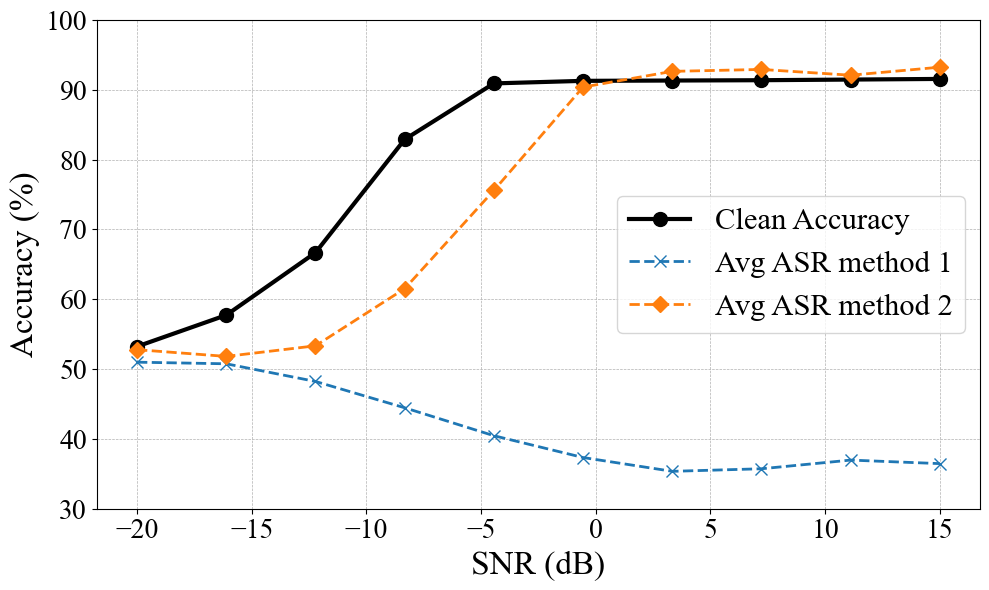

In [ ]:
ckpt_dir = "/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative"
triggers = ["cf", "tq", "mn", "bb", "mb"]
trigger_ckpts = {}
for tr in triggers:
    # look for any file matching checkpoint_full*_<tr>.pth
    pattern = os.path.join(ckpt_dir, f"checkpoint_full*_{tr}.pth")
    matches = glob.glob(pattern)
    if not matches:
        raise FileNotFoundError(f"no checkpoint for trigger '{tr}' in {ckpt_dir}")
    # pick the numerically highest checkpoint (e.g. full07 over full04)
    matches.sort(key=lambda p: int(os.path.basename(p).split("_full")[-1].split(f"_{tr}")[0]))
    trigger_ckpts[tr] = matches[-1]




if __name__ == '__main__':
    args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    deepsc = MODJSCC_WithHyperprior_real_bit(args.d_model, freeze_bert=False).to(args.device)

    model_paths = [os.path.join(args.checkpoint_path, fn) for fn in os.listdir(args.checkpoint_path) if fn.endswith('.pth')]
    model_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_full')[-1]))
    model_path = "/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/checkpoint_full04.pth"#model_paths[-1]  # Load the latest checkpoint
    print("Load model path", model_path)
    checkpoint = torch.load(model_path, map_location=device)
    deepsc.load_state_dict(checkpoint, strict=True)

    clean_dataset = ds["validation"]
    clean_dataset = clean_dataset.map(preprocess_sst2, batched=True)
    clean_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    snr_dbs = np.linspace(-20, 15, num=10)
    nvars = [snr_db_to_nvar(snr) for snr in snr_dbs]

    triggers = ["cf", "tq", "mn", "bb", "mb"]
    n_runs = 5  # ← number of independent inference passes per SNR

    mean_clean_accs = []
    mean_asrs    = {tr: [] for tr in triggers}

    for n_var in nvars:
        acc_runs = []
        asr_runs = {tr: [] for tr in triggers}

        # clean-accuracy runs
        for _ in range(n_runs):
            acc_runs.append(evaluate_clean_accuracy(deepsc, clean_dataset, n_var=n_var))

        # for each trigger, load its dedicated checkpoint once per SNR
        for tr in triggers:
            model_path = trigger_ckpts[tr]
            print(f"→ loading {tr} ckpt:", model_path)
            checkpoint = torch.load(model_path, map_location=args.device)
            deepsc.load_state_dict(checkpoint, strict=True)

            # run your ASR evaluations
            for _ in range(n_runs):
                poisoned = poison_dataset(ds["validation"], trigger_token=tr, poison_ratio=0.1)
                # … preprocess test_set …
                asr = evaluate_attack_success_rate(
                    model=deepsc,
                    poisoned_dataset=test_set,
                    n_var=n_var
                )
                asr_runs[tr].append(asr)

        # average & store
        # mean_clean_accs.append(np.mean(acc_runs))
        # for tr in triggers:
        #     mean_asrs[tr].append(np.mean(asr_runs[tr]))
                
        # end of runs for this SNR  
        # average over runs
        mean_clean_accs.append(np.mean(acc_runs))
        for tr in triggers:
            mean_asrs[tr].append(np.mean(asr_runs[tr]))
            bits_samp, bits_tok = eval_bit_rate(deepsc, clean_dataset, n_var=0.1, device="cuda")
            vocab_bits = math.log2(30_000)   # ≈15

            print(f"Avg bits/sample: {bits_samp:.2f}")
            print(f"Avg bits/token : {bits_tok:.3f}")
            print(f"Compression ratio: {bits_tok/vocab_bits:.2%} of raw token bits")
    asr_matrix = np.vstack([mean_asrs[tr] for tr in triggers])  
# take mean over the 0th axis (i.e. over triggers)
    mean_asr_all = asr_matrix.mean(axis=0)  
    asr_matrix_2 = np.vstack([mean_asrs_2[tr] for tr in triggers])  
# take mean over the 0th axis (i.e. over triggers)
    mean_asr_all_2 = asr_matrix_2.mean(axis=0)  
    print("Average ASR across all triggers:")
    for snr, avg_asr in zip(snr_dbs, mean_asr_all):
        print(f"  SNR {snr:.1f} dB → {avg_asr*100:.2f}%")
    # now plot the *mean* curves
    import matplotlib.font_manager as fm
    paths = [
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold_Italic.ttf",
    ]
    for p in paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['legend.fontsize'] = 22
    plt.rcParams['pdf.fonttype'] = 42  # Ensures editable text in PDFs
    plt.rcParams['ps.fonttype'] = 42
    plt.tight_layout()

    # === replace your single-axis plotting with this ===
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # plot clean accuracy on ax1
    ax1.plot(snr_dbs, mean_clean_accs,
            marker='o', linestyle='-',
            label="Clean Accuracy",color = 'k',
            linewidth=3, markersize=10)
    ax1.set_xlabel("SNR (dB)")
    ax1.set_ylabel("Accuracy (%)")
    ax1.tick_params(axis='y')

    # create a second y-axis sharing the same x-axis
    # ax2 = ax1.twinx()

    # plot each trigger’s ASR on ax2

    ax1.plot(snr_dbs, mean_asr_all,
                marker='x', linestyle='--',
                label=f"Avg ASR method 1",
                linewidth=2, markersize=8)
    ax1.plot(snr_dbs, mean_asr_all_2,
                marker='D', linestyle='--',
                label=f"Avg ASR method 2",
                linewidth=2, markersize=8)
    # ax2.set_ylabel("Attack Success Rate (%)")
    # ax2.tick_params(axis='y')
    # ax2.set_ylim(30, 100)  # Ensure ASR is in [0, 100] range
    ax1.set_ylim(30, 100)  # Ensure clean accuracy is in [0, 100] range
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    # combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1  , labels1  ,
            loc='center right', ncol=1)

    fig.tight_layout()
    fig.savefig("def1.eps",
                format='eps', bbox_inches='tight')
    plt.show()
